In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('adult_analysis').getOrCreate()
df = spark.read.csv('adult.csv', inferSchema = True, header=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [2]:
# from pyspark.sql.types import DoubleType

# numericColumns = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
# for numericCol in numericColumns:
#     df = df.withColumn(numericCol, df[numericCol].cast(DoubleType()))

In [3]:
# df.printSchema()

### 保存原始数据集的列

In [4]:
columns = df.columns

In [5]:
df.show(5)

+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|educational-num|    marital-status|       occupation|relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
| 25|  Private|226802|        11th|              7|     Never-married|Machine-op-inspct|   Own-child|Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|  Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male|           0|           0|            50| United-States| <=50K|
| 28|Local-gov|336951|  Assoc-acdm|             12|Married-civ-spouse|  Protective-serv|     Husband|White|  M

### Pandas dataframe展示效果比Spark DataFrame.show()方法更好

In [6]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,25,38,28,44,18
workclass,Private,Private,Local-gov,Private,?
fnlwgt,226802,89814,336951,160323,103497
education,11th,HS-grad,Assoc-acdm,Some-college,Some-college
educational-num,7,9,12,10,10
marital-status,Never-married,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Machine-op-inspct,Farming-fishing,Protective-serv,Machine-op-inspct,?
relationship,Own-child,Husband,Husband,Husband,Own-child
race,Black,White,White,Black,White
gender,Male,Male,Male,Male,Female


### 类别存在不平衡的现象

In [7]:
df.groupby('income').count().toPandas()

,income,count
0,<=50K,37155
1,>50K,11687


### 数值变量

In [8]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,48842,38.64358543876172,13.710509934443518,17,90
fnlwgt,48842,189664.13459727284,105604.02542315758,12285,1490400
educational-num,48842,10.078088530363212,2.570972755592256,1,16
capital-gain,48842,1079.0676262233324,7452.019057655418,0,99999
capital-loss,48842,87.50231358257237,403.00455212435924,0,4356
hours-per-week,48842,40.422382375824085,12.391444024252296,1,99


### 相关性矩阵(Correlations)

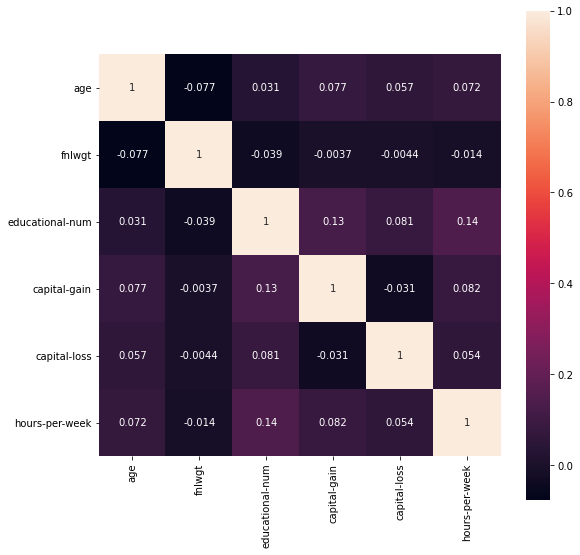

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.toPandas().corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(corr, annot=True, square=True)
fig = plt.gcf()
fig.savefig('HeatMap.png',dpi=300,bbox_inches='tight')

### 不进行归一化处理

In [10]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

# categoricalColumns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]
# stages = []

# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]

# label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
# stages += [label_stringIdx]

# numericCols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
# assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stages += [assembler]

### 进行归一化处理

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import MinMaxScaler, Normalizer, MaxAbsScaler

categoricalColumns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]

assembler1 = VectorAssembler(inputCols=numericCols, outputCol="raw_features")
mmScaler = MinMaxScaler(inputCol="raw_features", outputCol="part_features")
assembler2 = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumns] + ["part_features"], outputCol="features")

stages += [assembler1, mmScaler, assembler2]

In [12]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedcols = ["label", "features"] + columns
df = df.select(selectedcols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,1,1,0
features,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,25,38,28,44,18
workclass,Private,Private,Local-gov,Private,?
fnlwgt,226802,89814,336951,160323,103497
education,11th,HS-grad,Assoc-acdm,Some-college,Some-college
educational-num,7,9,12,10,10
marital-status,Never-married,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Machine-op-inspct,Farming-fishing,Protective-serv,Machine-op-inspct,?
relationship,Own-child,Husband,Husband,Husband,Own-child


In [14]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [15]:
train, test = df.randomSplit([0.7, 0.3], seed=100)
print(train.count())
print(test.count())

34255
14587


### Logistic Regression

In [16]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = 'label', featuresCol = 'features', maxIter=10)
lrModel = lr.fit(train)

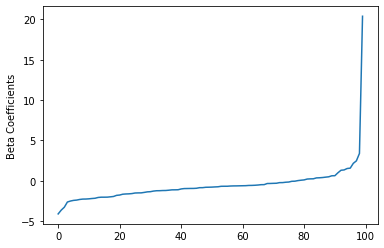

In [17]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [18]:
len(lrModel.coefficients)

100

In [19]:
lrModel.getParam

<bound method Params.getParam of LogisticRegressionModel: uid = LogisticRegression_3f91876c1c50, numClasses = 2, numFeatures = 100>

In [20]:
df.select('features').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(100,[0,13,24,35,45,49,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1095890410958904,0.1451287619704827,0.4,0.3979591836734694])                       |
|(100,[0,8,23,39,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2876712328767123,0.0524512639408977,0.5333333333333333,0.5])                        |
|(100,[2,14,23,41,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1506849315068493,0.2196486741559351,0.7333333333333333,0.3979591836734694])        |
|(100,[0,9,23,35,43,49

### ROC曲线

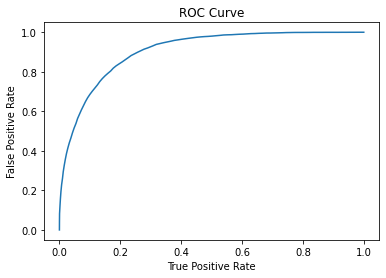

Training set areaUnderROC: 0.9054664611581362


In [21]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [22]:
trainingSummary.accuracy

0.8511458181287404

In [23]:
trainingSummary.recallByLabel

[0.9292968001532861, 0.6012254901960784]

### P-R曲线

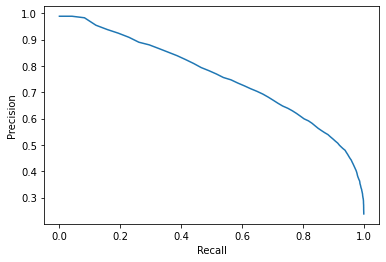

In [24]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [25]:
predictions = lrModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.68557498392007...|
| 30|  Private|  0.0|       0.0|[0.60426306453844...|
| 31|  Private|  0.0|       0.0|[0.65201466833880...|
| 32|  Private|  0.0|       0.0|[0.65240232189008...|
| 34|  Private|  0.0|       0.0|[0.65715845438230...|
| 42|  Private|  0.0|       0.0|[0.58526983807705...|
| 44|  Private|  0.0|       0.0|[0.62262654928846...|
| 46|  Private|  0.0|       0.0|[0.54805969492335...|
| 50|  Private|  0.0|       1.0|[0.23013319664760...|
| 51|  Private|  0.0|       0.0|[0.58649968069068...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.9027161176170866
Test Area Under PR 0.7611584515787215


In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.9013809511846349
Test Area Under PR 0.7570245681090048


In [29]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.9013809511846278
0.7570245681090042


### SVM

In [30]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol = 'features', labelCol = 'label')
svmModel = svm.fit(train)

In [31]:
predictions = svmModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [32]:
predictions.select('age', 'workclass', 'label','prediction', 'rawPrediction').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|       rawPrediction|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.53329679259527...|
| 30|  Private|  0.0|       0.0|[0.38944665723836...|
| 31|  Private|  0.0|       0.0|[0.47419759527449...|
| 32|  Private|  0.0|       0.0|[0.47554198359125...|
| 34|  Private|  0.0|       0.0|[0.48936444368918...|
| 42|  Private|  0.0|       0.0|[0.36553618015473...|
| 44|  Private|  0.0|       0.0|[0.43415765503529...|
| 46|  Private|  0.0|       0.0|[0.30890534383625...|
| 50|  Private|  0.0|       1.0|[-0.2812011506383...|
| 51|  Private|  0.0|       0.0|[0.37651004368263...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [33]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.9010023681945312
0.7649592991503452


In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5])
             .addGrid(lr.maxIter, [1, 5,])
             .build())

cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.9010023681945366
Test Area Under PR 0.7649592991503453


### Decision Trees

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [36]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  11
depth =  3


In [37]:
predictions = dtModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [38]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.69402110199296...|
| 30|  Private|  0.0|       0.0|[0.69402110199296...|
| 31|  Private|  0.0|       0.0|[0.69402110199296...|
| 32|  Private|  0.0|       0.0|[0.69402110199296...|
| 34|  Private|  0.0|       0.0|[0.69402110199296...|
| 42|  Private|  0.0|       0.0|[0.69402110199296...|
| 44|  Private|  0.0|       0.0|[0.69402110199296...|
| 46|  Private|  0.0|       0.0|[0.69402110199296...|
| 50|  Private|  0.0|       0.0|[0.69402110199296...|
| 51|  Private|  0.0|       0.0|[0.69402110199296...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [39]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.7671771521268889
0.57489388408616


In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.7940165917174205
0.5889976156796856


In [41]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.7940165917174205
0.5889976156796856


In [42]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

numNodes =  7
depth =  2


### Random Forest

In [43]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [44]:
predictions = rfModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [45]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.66652017208343...|
| 30|  Private|  0.0|       0.0|[0.66652017208343...|
| 31|  Private|  0.0|       0.0|[0.65110695389943...|
| 32|  Private|  0.0|       0.0|[0.65110695389943...|
| 34|  Private|  0.0|       0.0|[0.69479064819122...|
| 42|  Private|  0.0|       0.0|[0.63973689740226...|
| 44|  Private|  0.0|       0.0|[0.68819838430694...|
| 46|  Private|  0.0|       0.0|[0.68819838430694...|
| 50|  Private|  0.0|       0.0|[0.63973689740226...|
| 51|  Private|  0.0|       0.0|[0.68819838430694...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [46]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.8863923537925722
0.7291063589466605


In [47]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.8955315004734834
0.751326186180264


In [48]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.8955315004734832
0.7513261861802641


### Gradient-boosted Decision Tree

In [49]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10, )
gbtModel = gbt.fit(train)

In [50]:
predictions = gbtModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [51]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.77491272258376...|
| 30|  Private|  0.0|       0.0|[0.77491272258376...|
| 31|  Private|  0.0|       0.0|[0.76691113531725...|
| 32|  Private|  0.0|       0.0|[0.75788122016160...|
| 34|  Private|  0.0|       0.0|[0.64350949603309...|
| 42|  Private|  0.0|       0.0|[0.58529220767176...|
| 44|  Private|  0.0|       0.0|[0.62219499436556...|
| 46|  Private|  0.0|       0.0|[0.62219499436556...|
| 50|  Private|  0.0|       0.0|[0.58529220767176...|
| 51|  Private|  0.0|       0.0|[0.62219499436556...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [52]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.9053278480499946
0.7778842108450467


In [53]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6]) #最大树深
             .addGrid(gbt.maxBins, [20, 60]) #最大的划分数
             .addGrid(gbt.maxIter, [10, 20]) #最大迭代次数
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.917937240538122
0.8109496077951449


In [54]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.9179372405381211
0.8109496077951451


In [56]:
from pyspark.ml.linalg import SparseVector, DenseVector

importance = bestModel.featureImportances
importance_dense = DenseVector(importance)
importance_df = pd.DataFrame(importance_dense.array)
writer = pd.ExcelWriter('featureImportances_norm.xlsx')
importance_df.to_excel(writer, sheet_name='featureImportances_norm')
writer.save()